In [20]:
import datetime

import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yfin
from scipy import stats


yfin.pdr_override()

# Money at a floating rate for a secured purchase.

### For this task, we use the large-scale real-world mortgage dataset HMDA dataset from https://www.consumerfinance.gov/data-research/hmda/historic-data/?geo=ny&records=all-records&field_descriptions=labels. We take the data from 2 different years, specificlly 2007 and 2017.

In [2]:
hmda_file_2017 = r'Data\hmda_2007_ny_all-records_labels.csv'
hmda_data_2017 = pd.read_csv(hmda_file_2017)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15120\3446260447.py:2: DtypeWarning: Columns (34,36,38,42,44,46,48) have mixed types. Specify dtype option on import or set low_memory=False.
  hmda_data_2017 = pd.read_csv(hmda_file_2017)


In [3]:
hmda_file_2007 = r'Data\hmda_2017_ny_all-records_labels.csv'
hmda_data_2007 = pd.read_csv(hmda_file_2007)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15120\1201986362.py:2: DtypeWarning: Columns (34,36,38,44,46,48) have mixed types. Specify dtype option on import or set low_memory=False.
  hmda_data_2007 = pd.read_csv(hmda_file_2007)


In [4]:
hmda_data_2017['action_taken_name'].unique()

array(['Application denied by financial institution',
       'Loan purchased by the institution', 'Loan originated',
       'Application withdrawn by applicant',
       'Application approved but not accepted',
       'File closed for incompleteness',
       'Preapproval request denied by financial institution',
       'Preapproval request approved but not accepted'], dtype=object)

In [5]:
approved_set = ['Loan originated', 'Application approved but not accepted', 'Preapproval request approved but not accepted']
denined_set = ['Application denied by financial institution', 'Preapproval request denied by financial institution']

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC

def process_df(hmda_data_2017):
  # Simplify the model by selecting a subset of features
  selected_features = ["applicant_income_000s", "applicant_race_name_1", "applicant_sex_name", "co_applicant_race_name_1", "co_applicant_sex_name", "lien_status_name", "loan_purpose_name", "loan_type_name", "owner_occupancy_name", "hud_median_family_income", "loan_amount_000s", "number_of_1_to_4_family_units", "number_of_owner_occupied_units", "minority_population", "population"]

  # Preparing the dataset
  hmda_data_2017['loan_approved'] = hmda_data_2017['action_taken_name'].apply(lambda x: 1 if x in approved_set else 0 if x in denined_set else None)
  hmda_data_2017.dropna(subset=['loan_approved'], inplace=True)
  hmda_data_2017 = hmda_data_2017[selected_features + ['loan_approved']]
  X = hmda_data_2017.drop('loan_approved', axis=1)
  y = hmda_data_2017['loan_approved']

  # Convert categorical columns to strings to avoid type issues
  categorical_cols = X.select_dtypes(include=['object', 'category']).columns
  X[categorical_cols] = X[categorical_cols].astype(str)

  return X, y, categorical_cols

In [7]:
X, y, categorical_cols = process_df(hmda_data_2007)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing for numerical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X.select_dtypes(include=['int64', 'float64']).columns),
        ('cat', categorical_transformer, categorical_cols)])

# Define the model
model = RandomForestClassifier(random_state=42)
#model = SVC(kernel="linear", C=0.025, random_state=42)

# Bundle preprocessing and modeling code in a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])

# Preprocessing of training data, fit model
pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, preds)
classification_rep = classification_report(y_test, preds)

print("Model Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)


Model Accuracy: 0.7959053103007038
Classification Report:
               precision    recall  f1-score   support

         0.0       0.55      0.26      0.35     13748
         1.0       0.82      0.94      0.88     50335

    accuracy                           0.80     64083
   macro avg       0.69      0.60      0.62     64083
weighted avg       0.77      0.80      0.77     64083



In [8]:
X_future, y_future, _ = process_df(hmda_data_2017)
preds = pipeline.predict(X_future)
# Evaluate the model
accuracy = accuracy_score(y_future, preds)
classification_rep = classification_report(y_future, preds)

print("Model Accuracy (Future):", accuracy)
print("Classification Report（Future):\n", classification_rep)

Model Accuracy (Future): 0.6610688361747671
Classification Report（Future):
               precision    recall  f1-score   support

         0.0       0.58      0.15      0.24    265899
         1.0       0.67      0.94      0.78    486714

    accuracy                           0.66    752613
   macro avg       0.62      0.55      0.51    752613
weighted avg       0.64      0.66      0.59    752613



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15120\2354990139.py:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels


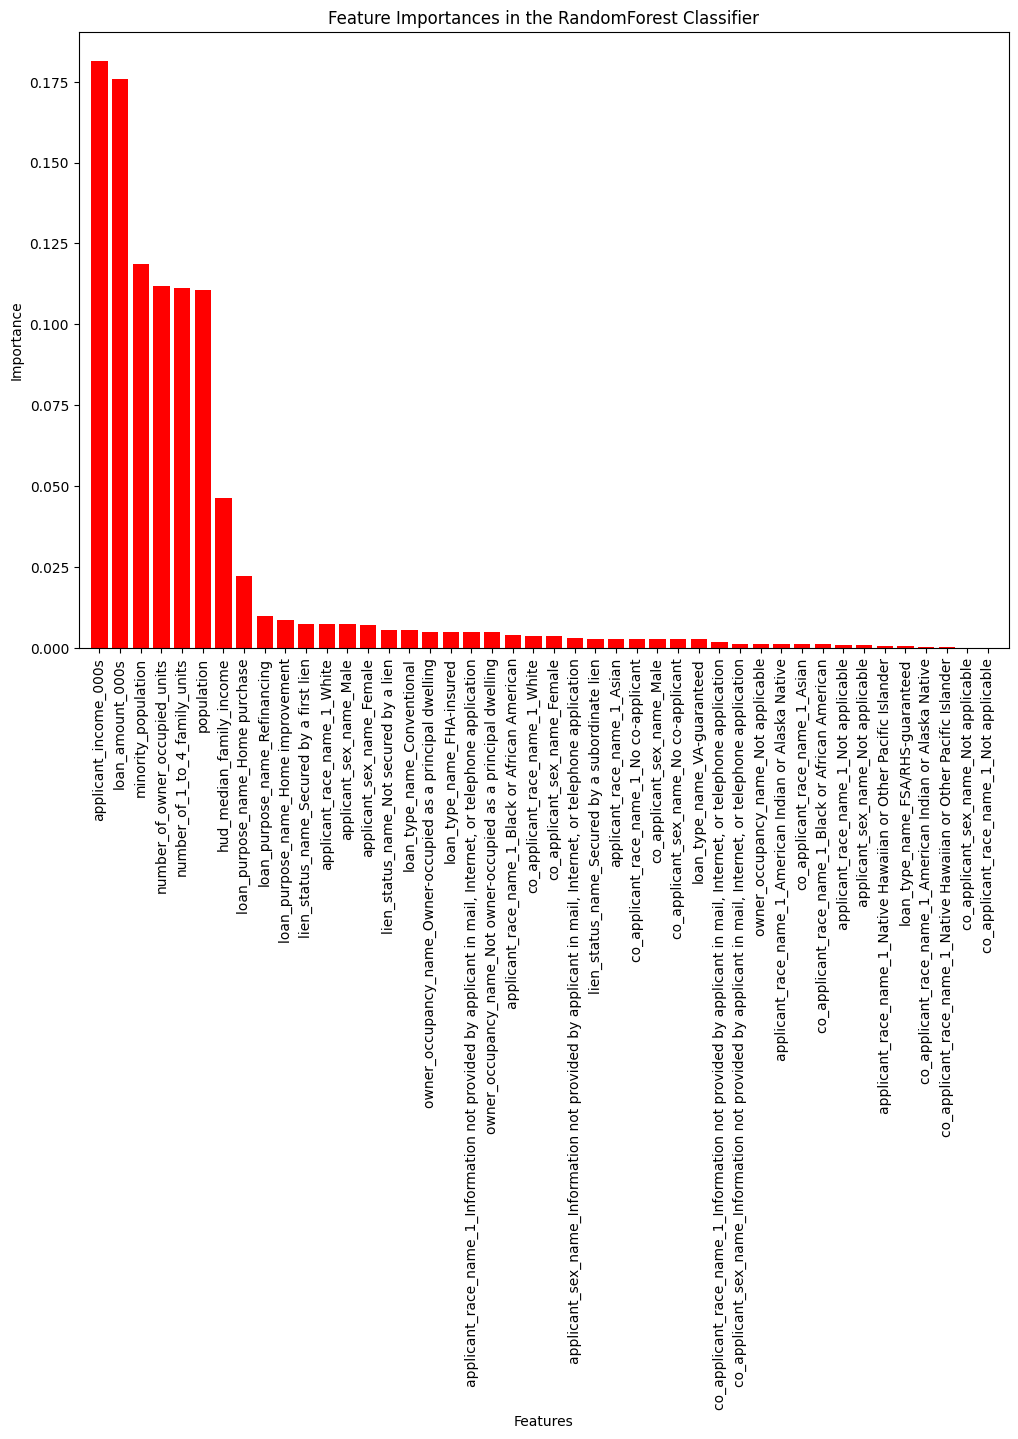

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Retrieve the feature importances from the trained RandomForestClassifier
feature_importances = pipeline.named_steps['model'].feature_importances_

# Get the feature names after one-hot encoding
feature_names_transformed = pipeline.named_steps['preprocessor'].transformers_[1][1]\
    .named_steps['onehot'].get_feature_names_out(input_features=categorical_cols)

# Combine with numeric feature names
feature_names = np.concatenate([X.select_dtypes(include=['int64', 'float64']).columns, feature_names_transformed])

# Sort the features by importance
indices = np.argsort(feature_importances)[::-1]

# Visualize the feature importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importances in the RandomForest Classifier")
plt.bar(range(len(feature_importances)), feature_importances[indices], color="r", align="center")
plt.xticks(range(len(feature_importances)), feature_names[indices], rotation=90)
plt.xlim([-1, len(feature_importances)])
plt.ylabel('Importance')
plt.xlabel('Features')
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()


# Publicly traded Equity (e.g. common stock) – that is, securities lending of a stock.

## NVIDIA Stock Analysis

In [10]:
#To analyze a publicly traded stock I have used 5 years of NVIDIA data using yahoo finance as my data source

In [11]:
#Downloading the data using yahoo Finance
import datetime
start = datetime.date(2019, 1, 1)
end = datetime.date(2023, 12, 31)
df = web.DataReader(["NVDA"], start, end)

[*********************100%%**********************]  1 of 1 completed


In [12]:
df_VIXN = web.DataReader(["^VIX"], start, end)["Adj Close"]

[*********************100%%**********************]  1 of 1 completed


In [13]:
#Merging the VIX index data with our NVDIA dataset
df = df.merge(df_VIXN, on="Date", how="outer")
df.rename(columns={'Adj Close_y': 'VIX index'}, inplace=True)
df.describe()

,Open,High,Low,Close,Adj Close_x,Volume,VIX index
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1258.000000
mean,177.352243,180.632174,173.983038,177.463569,177.238881,4.626251e+07,21.367917
std,124.757333,126.716487,122.525187,124.675773,124.722888,1.998936e+07,8.238798
min,32.660000,33.790001,31.922501,31.997499,31.748959,9.788400e+06,11.540000
25%,69.150000,70.550625,67.028126,68.320625,68.064875,3.246800e+07,15.960000
50%,145.784996,148.631248,142.300003,145.820000,145.548172,4.319750e+07,19.525001
75%,231.895000,236.667503,225.437496,230.927502,230.648735,5.645790e+07,24.799999
max,502.160004,505.480011,494.119995,504.089996,504.045685,2.511528e+08,82.690002


In [14]:
#Viewing the data
df.head()

,Open,High,Low,Close,Adj Close_x,Volume,VIX index
Date,,,,,,,
2019-01-02,32.660000,34.619999,32.512501,34.055000,33.790470,50875200,23.219999
2019-01-03,33.447498,33.790001,31.922501,31.997499,31.748959,70555200,25.450001
2019-01-04,32.735001,34.432499,32.424999,34.047501,33.783039,58562000,21.379999
2019-01-07,34.625000,36.222500,34.107498,35.849998,35.571529,70916000,21.400000
2019-01-08,36.672501,36.695000,34.224998,34.957500,34.685970,78601600,20.469999


In [15]:
#stats Summary of our data
df.describe()

,Open,High,Low,Close,Adj Close_x,Volume,VIX index
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1258.000000
mean,177.352243,180.632174,173.983038,177.463569,177.238881,4.626251e+07,21.367917
std,124.757333,126.716487,122.525187,124.675773,124.722888,1.998936e+07,8.238798
min,32.660000,33.790001,31.922501,31.997499,31.748959,9.788400e+06,11.540000
25%,69.150000,70.550625,67.028126,68.320625,68.064875,3.246800e+07,15.960000
50%,145.784996,148.631248,142.300003,145.820000,145.548172,4.319750e+07,19.525001
75%,231.895000,236.667503,225.437496,230.927502,230.648735,5.645790e+07,24.799999
max,502.160004,505.480011,494.119995,504.089996,504.045685,2.511528e+08,82.690002


### Time Series Analysis

<Axes: title={'center': "NVIDIA's stock price"}, xlabel='Date'>

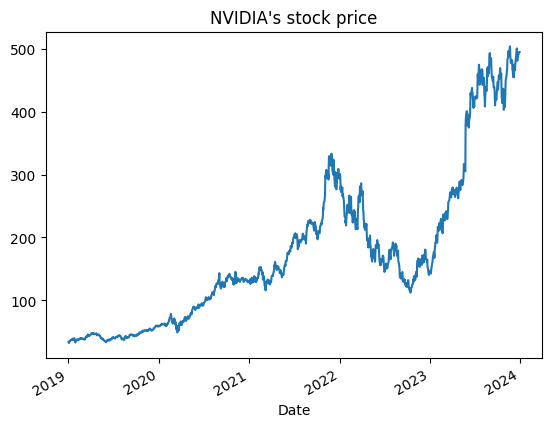

In [16]:
#Plotting the time series data
df['Adj Close_x'].plot(title="NVIDIA's stock price")

Time Series data from 2019-2023 of NVDIA stock

In [17]:
# Importing Plotply for Plotting
import plotly.graph_objects as go
from datetime import datetime

In [18]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close_x', 'Volume', 'VIX index'], dtype='object')

In [19]:
# Plotting stokck price data in candlestick pattern
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])

fig.show()

CandleStick Pattern oF NVDIA stock data

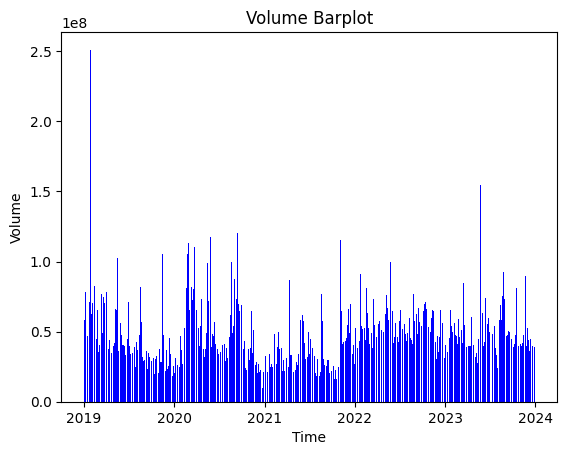

In [20]:
# Yearly volume Bar grph plot
plt.bar(df.index, df['Volume'], width=1.5, color='Blue')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.title('Volume Barplot')
plt.show()

Here you can see Volume traded in NVDIA stock each year

### Distribution Analysis

In [21]:
# Calculating Daily Returns
df['Daily_Return'] = df['Adj Close_x'].pct_change()

In [22]:
#Log returns
df['log_Return'] = np.log(df['Adj Close_x']) - np.log(df['Adj Close_x'].shift(1))

In [23]:
Max1 = df["log_Return"].max()
Min1 = df["log_Return"].min()
Max2 = (df["log_Return"].min() - df["log_Return"].mean()) / df["log_Return"].std()
Min2 = (df["log_Return"].max() - df["log_Return"].mean()) / df["log_Return"].std()
print("Over the last 5 years, NVDIA has had a maximum daily return of %.2f and a minimum daily return of %.2f If we use the formula to determine standard deviations from the mean, we get %.2f and %.2f standard deviations away from the mean for the minimum and maximum, respectively"%(Max1, Min1, Max2, Min2))

Over the last 5 years, NVDIA has had a maximum daily return of 0.22 and a minimum daily return of -0.20 If we use the formula to determine standard deviations from the mean, we get -6.35 and 6.66 standard deviations away from the mean for the minimum and maximum, respectively


In [24]:
df.log_Return

Date
2019-01-02         NaN
2019-01-03   -0.062319
2019-01-04    0.062099
2019-01-07    0.051587
2019-01-08   -0.025210
                ...   
2023-12-22   -0.003271
2023-12-26    0.009153
2023-12-27    0.002796
2023-12-28    0.002122
2023-12-29    0.000000
Name: log_Return, Length: 1258, dtype: float64

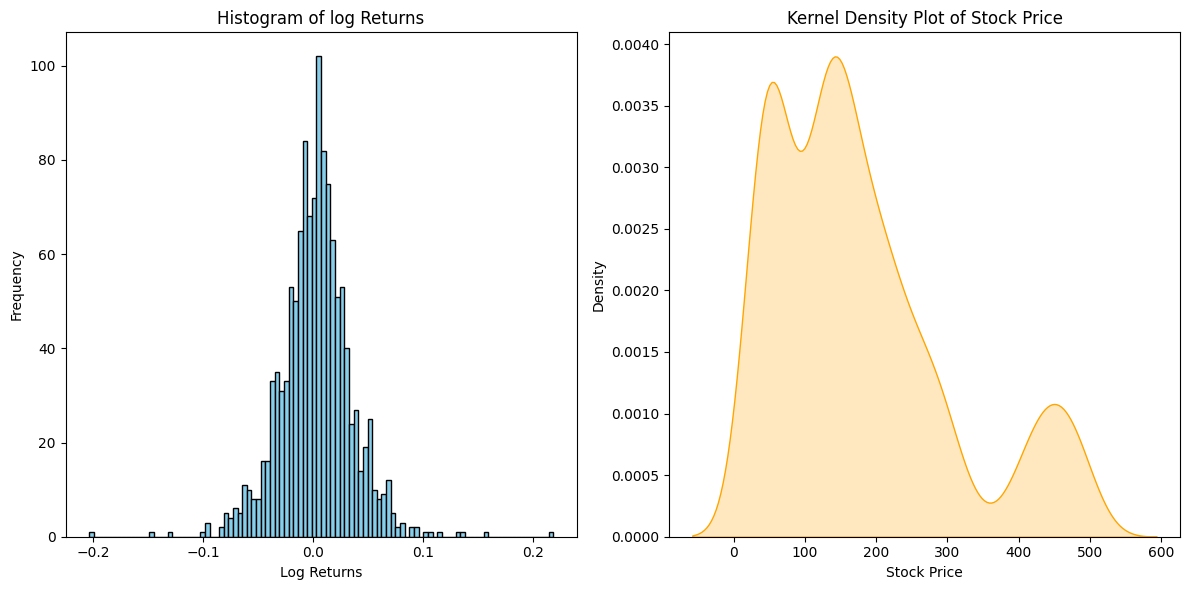

In [25]:
# Plot Histogram of Daily Returns
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(df['log_Return'], bins=100, color='skyblue', edgecolor='black')
plt.title('Histogram of log Returns')
plt.xlabel('Log Returns')
plt.ylabel('Frequency')

# Plot Kernel Density Plot
plt.subplot(1, 2, 2)
sns.kdeplot(df['Adj Close_x'], fill=True, color='orange')
plt.title('Kernel Density Plot of Stock Price')
plt.xlabel('Stock Price')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

Here we can see the log returns of NVDIA price in a normal distribution, we will learn more about the distribution in further section.
Also with that we have kernel density plot of NVDIA price where we can see the price is more dence between 0-300 price range.

### Statsical anlysis

In [26]:
df['Adj Close_x']

Date
2019-01-02     33.790470
2019-01-03     31.748959
2019-01-04     33.783039
2019-01-07     35.571529
2019-01-08     34.685970
                 ...    
2023-12-22    488.299988
2023-12-26    492.790009
2023-12-27    494.170013
2023-12-28    495.220001
2023-12-29    495.220001
Name: Adj Close_x, Length: 1258, dtype: float64

In [27]:
# Defining the log return into another data frame for ease of writing code.
df_stats = np.log(df['Adj Close_x']) - np.log(df['Adj Close_x'].shift(1))
df_stats

Date
2019-01-02         NaN
2019-01-03   -0.062319
2019-01-04    0.062099
2019-01-07    0.051587
2019-01-08   -0.025210
                ...   
2023-12-22   -0.003271
2023-12-26    0.009153
2023-12-27    0.002796
2023-12-28    0.002122
2023-12-29    0.000000
Name: Adj Close_x, Length: 1258, dtype: float64

In [28]:
df_stats.describe()

count    1257.000000
mean        0.002136
std         0.032449
min        -0.203979
25%        -0.015275
50%         0.003049
75%         0.019616
max         0.218088
Name: Adj Close_x, dtype: float64

In [29]:
#Symmetric Test
(len(df[df_stats > df_stats.mean()])) / (len(df))

0.5151033386327504

We're getting about 51.5% of data points being greater than the mean, which shows we have a slightly negative skew to this dataset. We can't rule out symmetric returns based on this since it is only a sample of data and is reasonably close to the 50% mark. This makes it hard to say for certain whether NVDA returns are symmetric or not, but it is still a reasonable assumption to make here.

In [30]:
  ##Normality Test
stats.normaltest(np.array(df["log_Return"].dropna()))

NormaltestResult(statistic=123.17405909425376, pvalue=1.790988968609061e-27)

We can use the `normaltest()` method here to determine if the sample data could fit a normal distribution. This method uses D'Agostino and Pearson's normality test, which combines skew and kurtosis to produce an omnibus test of normality.

The null hypothesis of this test is that the sample data fits a normal distribution. Let's assume we want to be 90% confident this data fits a normal distribution. We can compare this to the p-value to see if it's greater than 90%. In this case, the value, 1.79e-27, is extremely small, which leads us to reject the null hypothesis that this data fits a normal distribution.

In [31]:
  ##Skewness and Kurtosis
stats.jarque_bera((np.array(df["log_Return"].dropna())))

SignificanceResult(statistic=857.2987121001881, pvalue=6.917513192470387e-187)

The Jarque-Bera test was conducted on the log returns data. The test resulted in a statistic of 857.2981128421397 and an extremely low p-value of 6.919586190747671e-187. This indicates strong evidence against the null hypothesis that the data follows a normal distribution. Therefore, the log returns data is found to be significantly non-normally distributed based on the results of the Jarque-Bera test.

In [32]:
df_stats.min()

-0.20397943170647892

In [33]:
df_stats.max()

0.2180878060373761

In [34]:
dfMax = df_stats.max()
dfMin = df_stats.min()
print(
    "Min return of sample data is %.4f and the maximum return of sample data is %.4f"
    % (dfMin, dfMax)
)

Min return of sample data is -0.2040 and the maximum return of sample data is 0.2181


In [35]:
(dfMin - df_stats.mean()) / df_stats.std()

-6.351960017579849

In [36]:
(dfMax - df_stats.mean()) / df_stats.std()

6.655098835136092

Over the last 5 years, NVDA has had a maximum daily return of 20.40% and a minimum daily return of -21.80%. If we use the formula to determine standard deviations from the mean, we get -6.35 and 6.65 standard deviations away from the mean for the minimum and maximum, respectively. These standard deviations are humongous when compared to the normal distribution. We can see this analytically when we plug in the z score to the `norm.cdf()` method to determine the probability this value could be in a normal distribution:

In [37]:
stats.norm.cdf(-6.35)

1.0765746385121636e-10

This implies that the chance we could have a move as small as -21.80%, is 1.0765746385121636e-10. This probability is so low that we would never expect an event like this to happen in our lifetime. We have multiple events like this, as illustrated by the minimum and maximum.

Going further with this idea, based on normal distribution z tables, we would expect 99.7% of our data points to be within +/- 3 standard deviations from the mean. Let's determine this for our sample data. First off, we need to find the cut-off values at +/- 3 standard deviations:

In [38]:
(3 * df_stats.std()) + df_stats.mean()


0.09948317093152743

In [39]:
(-3 * df_stats.std()) + df_stats.mean()

-0.09521137570953363

The above two calculations would imply that 99.7% of all of our data points should be in between -0.0952 and 0.0994.

In [40]:
df[(df['log_Return'] > 0.03699) | (df['log_Return'] < -0.0364)]['log_Return'].tail()

Date
2023-10-17   -0.047925
2023-10-18   -0.040454
2023-10-23    0.037652
2023-10-25   -0.044107
2023-11-01    0.037186
Name: log_Return, dtype: float64

In [41]:
len(df[(df['log_Return'] > 0.03699) | (df['log_Return'] < -0.0364)])

264

In [42]:
len(df[(df["log_Return"] > 0.05) | (df["log_Return"] < -0.05)])

139

Not only do we get 264 values outside of our 3 standard deviation range, but we also get 139 values outside of +/- 5%, though you would almost never expect one of these events over 5 years, given a normal distribution.

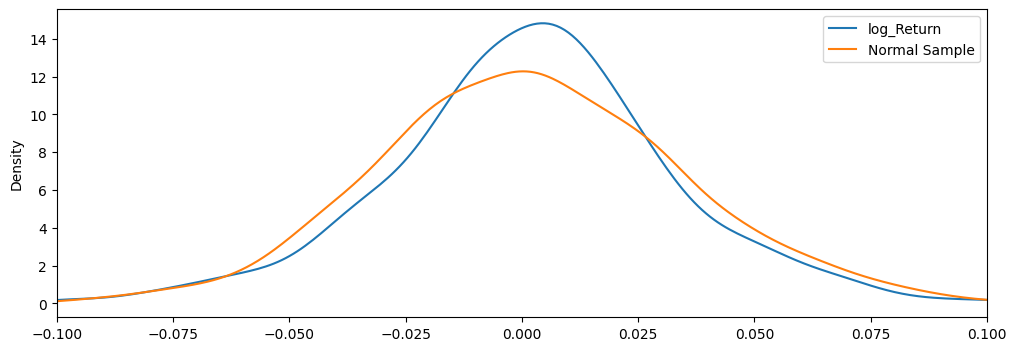

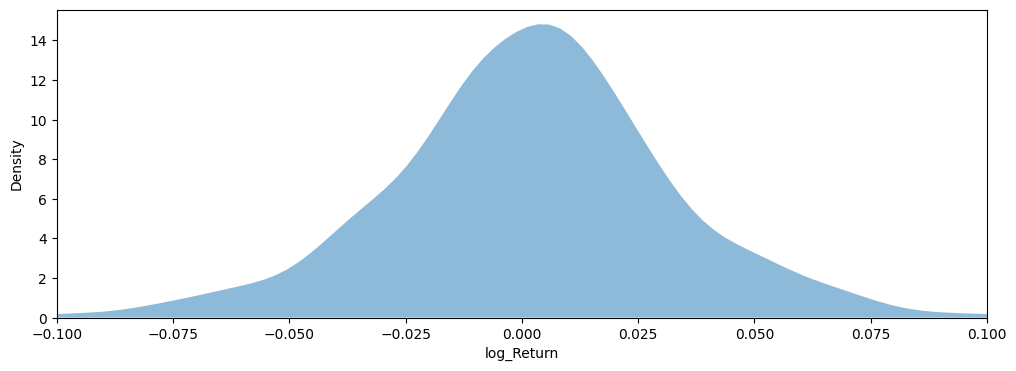

In [43]:
# Sampling from normal distribution
np.random.seed(222)
normal_dist = stats.norm.rvs(
    size=len(df["log_Return"]), loc=df["log_Return"].mean(), scale=df["log_Return"].std()
)

# Creating an additional column in df in order to use the KDE plot functionality of pandas
df["Normal Sample"] = normal_dist

# Plotting the KDE plots
df[["log_Return", "Normal Sample"]].plot(kind="kde", xlim=(-0.1, 0.1), figsize=(12, 4))

#Using Seaborn to create KDE
plt.figure(figsize = (12,4))
kde = sns.kdeplot(df["log_Return"], fill=True, alpha=.5, linewidth=0).set_xlim(-0.1, 0.1);

The NVDA returns seem a lot more leptokurtic. Indeed the excess kurtosis of NVDA is greater than 0:


In [44]:
df_stats.kurt()

4.065427250019263

The tails of NDA are also fatter than those of a normal distribution:

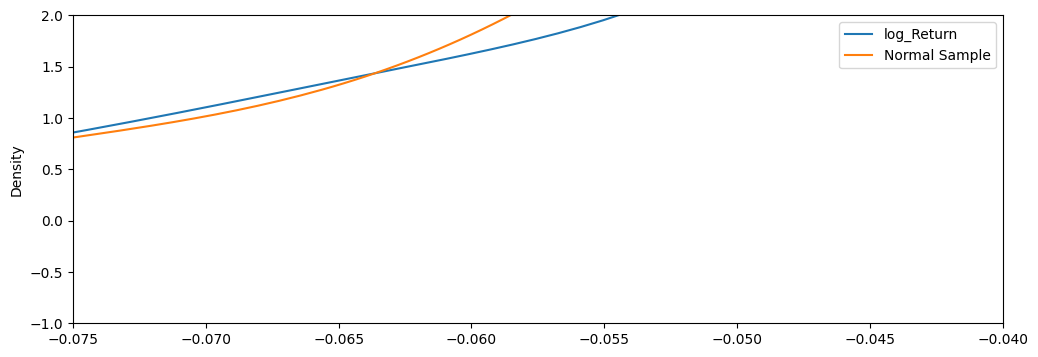

In [45]:
# Observing the tails
df[["log_Return", "Normal Sample"]].plot(
    kind="kde", xlim=(-0.075, -0.04), ylim=(-1, 2), figsize=(12, 4)
);

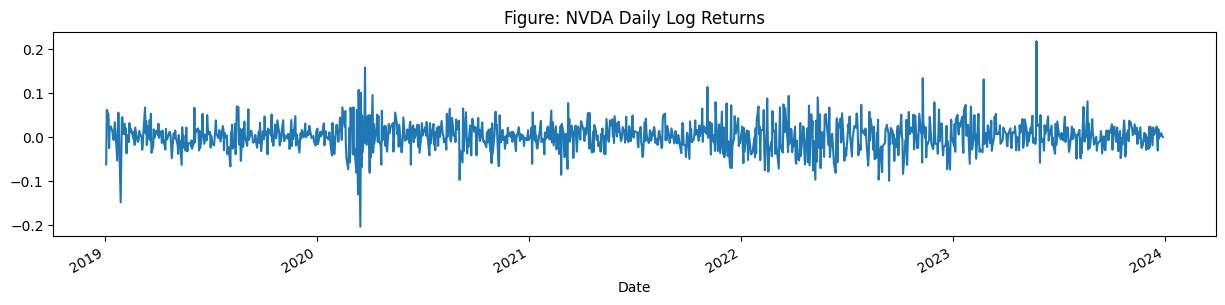

In [46]:
ax1 = df_stats.plot(figsize=(15, 3), y="NVDA", title="Figure: NVDA Daily Log Returns")

Daily Log Return graph

In [47]:
nvda_std = df_stats.std()
nvda_mean = df_stats.mean()

In [48]:
# Sharpe Ratio
Sharpe_Ratio_NVDA = nvda_mean / nvda_std
Sharpe_Ratio_NVDA

0.06582303350081951

The calculated Sharpe Ratio for the given data (NVDA) is approximately 0.0658. This ratio represents the risk-adjusted return, and in this case, a Sharpe Ratio of 0.0658 indicates the excess return per unit of risk for the NVDA investment.

In [49]:
# Semi-Variance
nvda_semivariance = ((df[df_stats < nvda_mean]["log_Return"] - nvda_mean) ** 2).mean()
nvda_semivariance

0.0010849321459611332

The calculated semi-variance for the NVDA log returns data is approximately 0.00108. This semi-variance is a measure of the average squared deviation of returns below the mean, providing insight into the downside risk associated with the NVDA investment.

### Relationship Analysis

In [50]:
# Create a new DataFrame with relevant columns for correlation analysis
correlation_df = df[['Adj Close_x', 'Volume', 'log_Return', 'VIX index']]


In [51]:
# Calculate the correlation matrix
correlation_matrix = correlation_df.corr()
correlation_matrix

,Adj Close_x,Volume,log_Return,VIX index
Adj Close_x,1.000000,-0.000330,0.019155,-0.224991
Volume,-0.000330,1.000000,0.043212,0.283252
log_Return,0.019155,0.043212,1.000000,-0.105276
VIX index,-0.224991,0.283252,-0.105276,1.000000


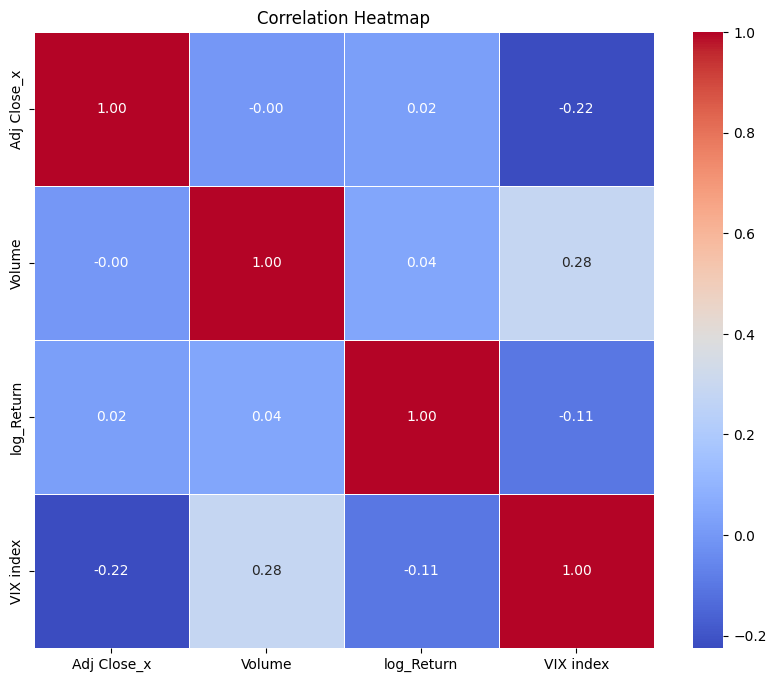

In [52]:
# Plot Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

Correlation between columns Adj Close_x, Volume, VIX Index, Log Return

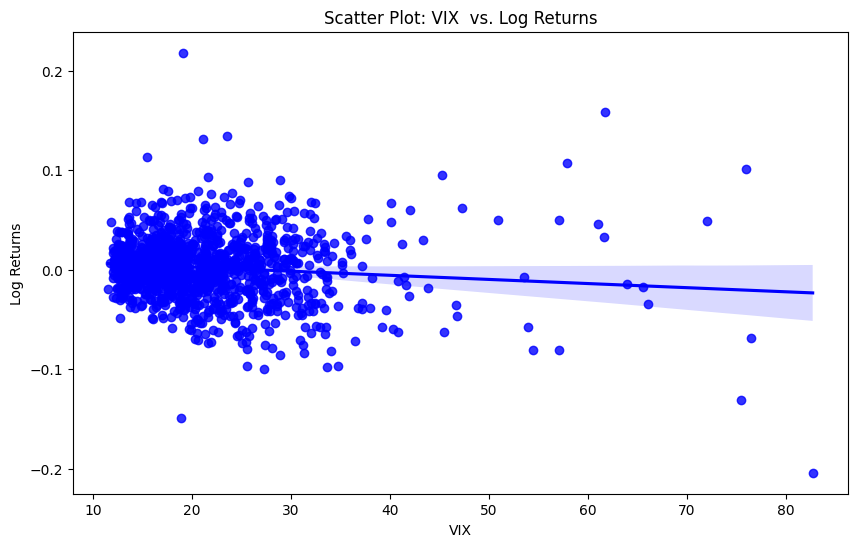

In [53]:
# Scatter Plot: Relationship between Trading Volume and Stock Returns
plt.figure(figsize=(10, 6))
sns.regplot(x='VIX index', y='log_Return', data=df, color='blue')
plt.title('Scatter Plot: VIX  vs. Log Returns')
plt.xlabel('VIX')
plt.ylabel('Log Returns')
plt.show()

In the above Correlation matrix Heatmap we have seen an negative realtionship between VIX return and Log retruns and we can confirm the same in the regplot below as we can the regression line slopping downwards and it concludes that volatitly in market has a slightly negative coorealtion with (NVDA) retruns.

### Liquidity Analysis

In [54]:
# Volume data
nvda_volume = df['Volume']
nvda_bid_ask_spread = df['High'] - df['Low']

In [55]:
# Calculating average daily trading volume and average bid-ask spread
average_daily_volume = nvda_volume.mean()
average_bid_ask_spread = nvda_bid_ask_spread.mean()


In [56]:
# Printing average daily volume and bid-ask spread
print(f"Average Daily Volume: {average_daily_volume:.2f}")
print(f"Average Bid-Ask Spread: {average_bid_ask_spread:.4f}")

Average Daily Volume: 46262513.43
Average Bid-Ask Spread: 6.6491


An average daily trading volume of 46,262,513.43 shares, suggesting a notable level of market activity. Additionally, the average bid-ask spread of 6.6491 indicates a moderate level of liquidity.

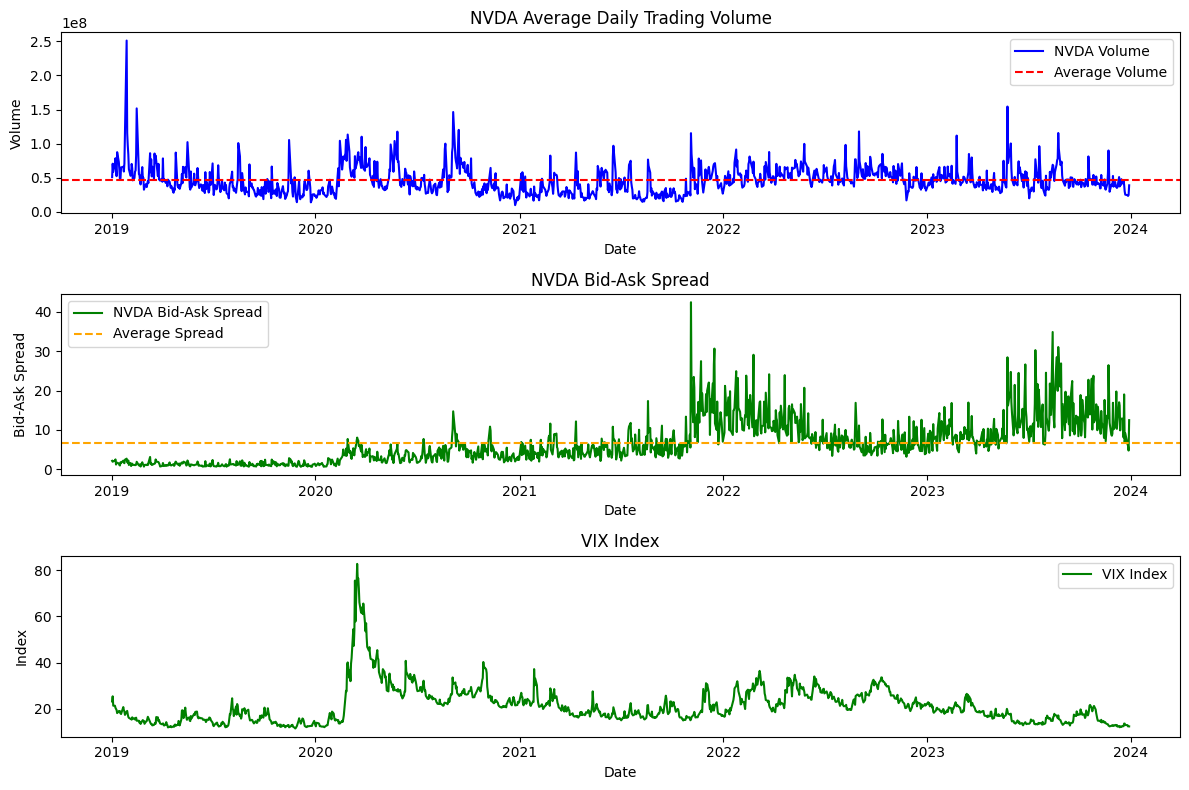

In [57]:
# Plotting average daily volume and bid-ask spread
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8))

# Plotting average daily volume
ax1.plot(nvda_volume, label="NVDA Volume", color='blue')
ax1.axhline(average_daily_volume, color='red', linestyle='--', label='Average Volume')
ax1.set_title("NVDA Average Daily Trading Volume")
ax1.set_xlabel("Date")
ax1.set_ylabel("Volume")
ax1.legend()

# Plotting bid-ask spread
ax2.plot(nvda_bid_ask_spread, label="NVDA Bid-Ask Spread", color='green')
ax2.axhline(average_bid_ask_spread, color='orange', linestyle='--', label='Average Spread')
ax2.set_title("NVDA Bid-Ask Spread")
ax2.set_xlabel("Date")
ax2.set_ylabel("Bid-Ask Spread")
ax2.legend()

# Plotting VIX index
ax3.plot(df["VIX index"], label="VIX Index", color='green')
ax3.set_title("VIX Index")
ax3.set_xlabel("Date")
ax3.set_ylabel("Index")
ax3.legend()

plt.tight_layout()
plt.show()

This visualizations offer a comprehensive overview of NVDA's trading dynamics, bid-ask spread variations, and the broader market volatility captured by the VIX Index. (All the key Insights is Completely explained in Project Doc Step 6)

### Volatility Analysis

In [58]:
df.head()

,Open,High,Low,Close,Adj Close_x,Volume,VIX index,Daily_Return,log_Return,Normal Sample
Date,,,,,,,,,,
2019-01-02,32.660000,34.619999,32.512501,34.055000,33.790470,50875200,23.219999,NaN,NaN,0.065847
2019-01-03,33.447498,33.790001,31.922501,31.997499,31.748959,70555200,25.450001,-0.060417,-0.062319,0.011084
2019-01-04,32.735001,34.432499,32.424999,34.047501,33.783039,58562000,21.379999,0.064068,0.062099,0.017019
2019-01-07,34.625000,36.222500,34.107498,35.849998,35.571529,70916000,21.400000,0.052940,0.051587,0.034626
2019-01-08,36.672501,36.695000,34.224998,34.957500,34.685970,78601600,20.469999,-0.024895,-0.025210,-0.022650


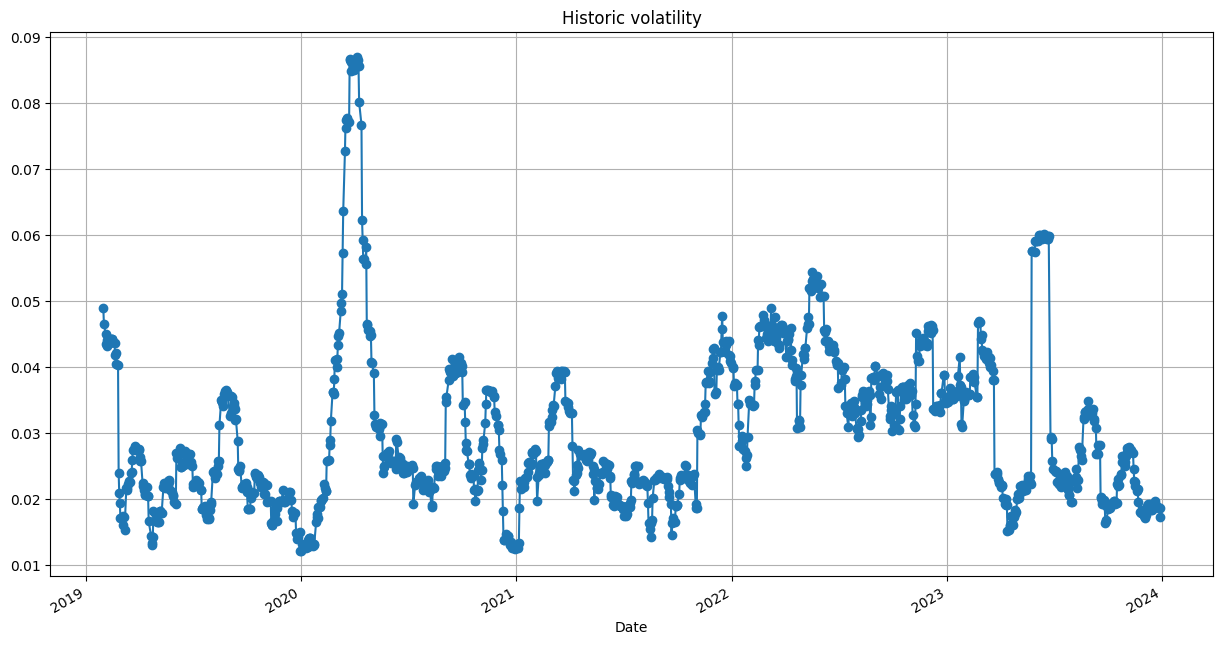

In [59]:
# Calculating historic volatility
df['Volatility'] = df['Close'].pct_change().rolling(window=20).std()
df['Volatility'].plot(title="Historic volatility", figsize=(15, 8), marker='o', linestyle='-')
plt.grid(True)

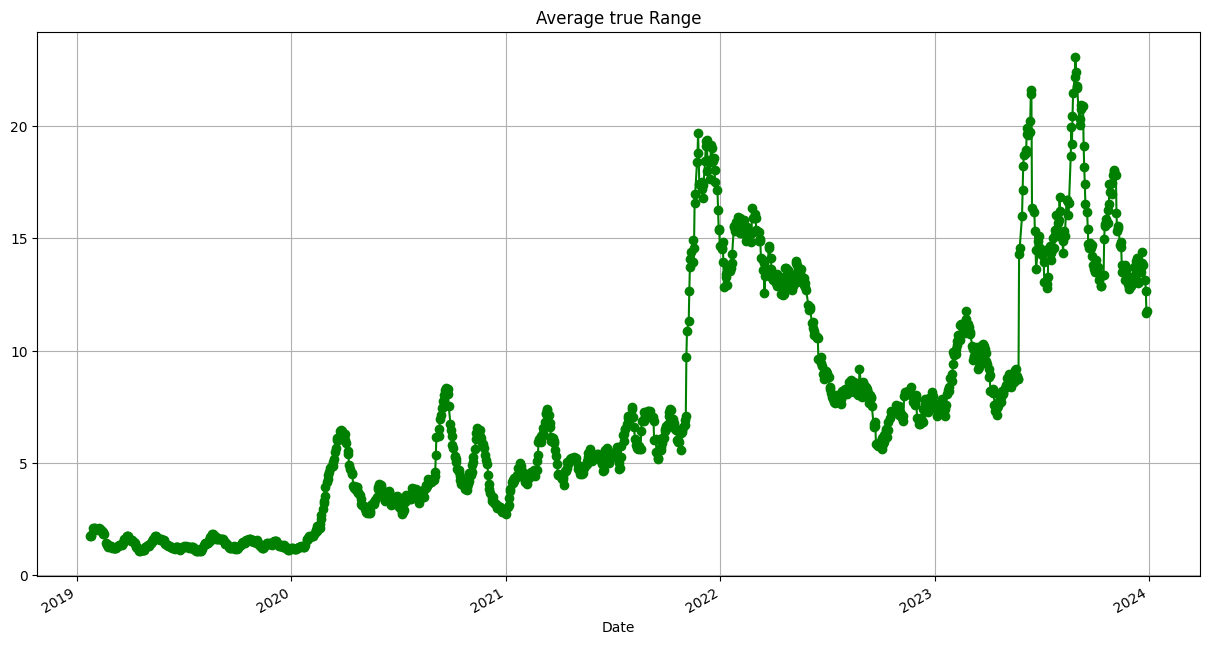

In [60]:
# ATR (Average true Range)

n = 15

# Calculate True Range (TR)
df['High-Low'] = df['High'] - df['Low']
df['High-PrevClose'] = abs(df['High'] - df['Close'].shift(1))
df['Low-PrevClose'] = abs(df['Low'] - df['Close'].shift(1))
df['TrueRange'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)

# Calculate ATR
df['ATR'] = df['TrueRange'].rolling(window=n).mean()

# Drop intermediate columns
df.drop(['High-Low', 'High-PrevClose', 'Low-PrevClose', 'TrueRange'], axis=1, inplace=True)

df['ATR'].plot(title="Average true Range", figsize=(15, 8), marker='o', linestyle='-', color='g')
plt.grid(True)

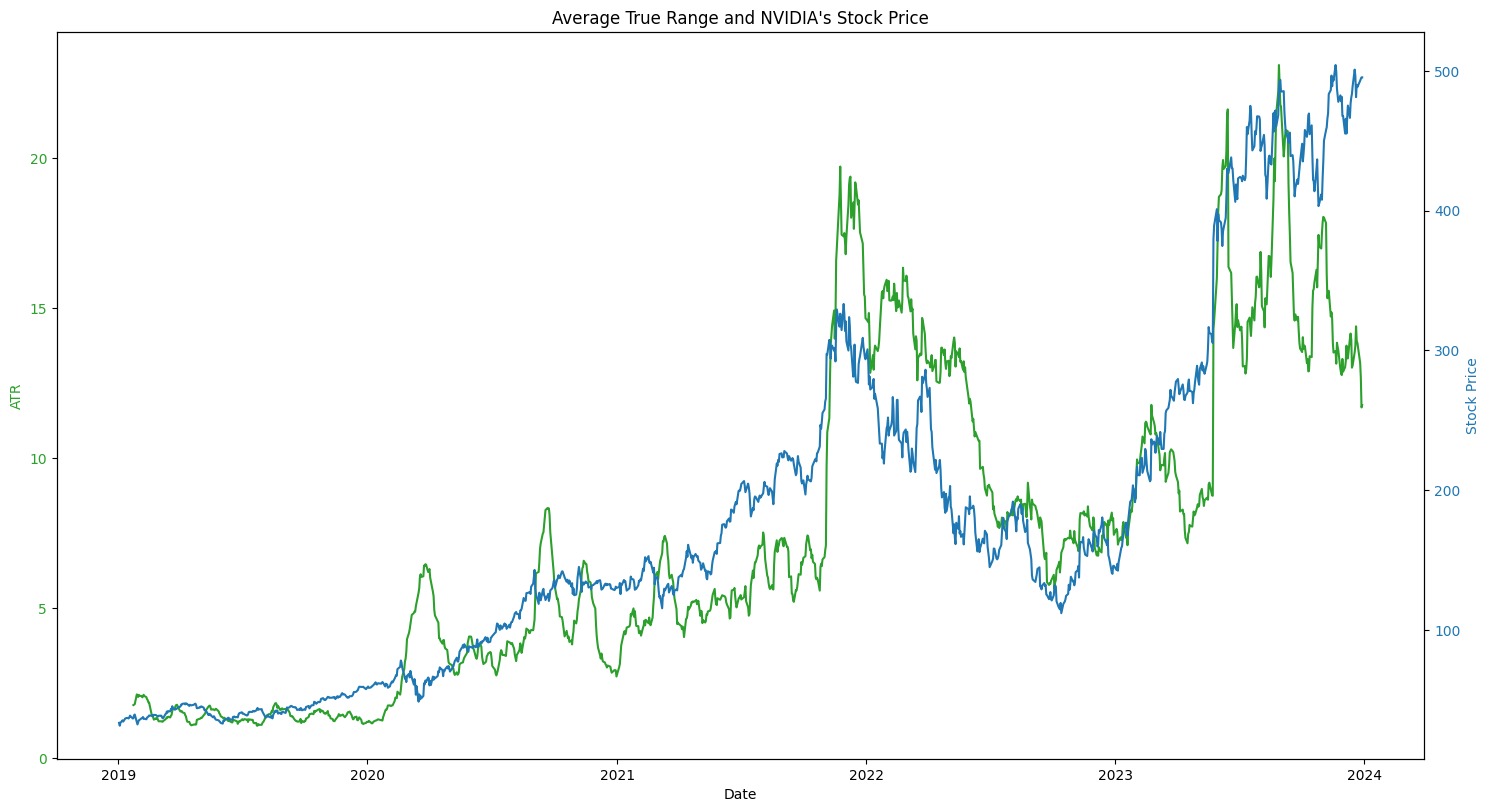

In [61]:
import matplotlib.pyplot as plt

# Assuming df DataFrame is already defined

n = 15

# Calculate True Range (TR)
df['High-Low'] = df['High'] - df['Low']
df['High-PrevClose'] = abs(df['High'] - df['Close'].shift(1))
df['Low-PrevClose'] = abs(df['Low'] - df['Close'].shift(1))
df['TrueRange'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)

# Calculate ATR
df['ATR'] = df['TrueRange'].rolling(window=n).mean()

# Drop intermediate columns
df.drop(['High-Low', 'High-PrevClose', 'Low-PrevClose', 'TrueRange'], axis=1, inplace=True)

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(15, 8))

# Plotting the ATR on the left y-axis
color = 'tab:green'
ax1.set_xlabel('Date')
ax1.set_ylabel('ATR', color=color)
ax1.plot(df.index, df['ATR'], label="ATR", color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a twin Axes for the stock price on the right y-axis
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Stock Price', color=color)
ax2.plot(df.index, df['Adj Close_x'], label="Stock Price", color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Display the plots
fig.tight_layout()
plt.title("Average True Range and NVIDIA's Stock Price")
plt.show()


Average True Range (ATR) is a technical indicator designed to measure market volatility. It considers the trading range (high to low) for a financial instrument over a specified time period, accounting for gaps between consecutive days. Higher ATR values imply greater market volatility.
Lower ATR values suggest a more stable market environment.

### Leverage Analysis

In [62]:
# VIX relationship
correlation_vol = df['Close'].corr(df['VIX index'])
correlation_vol

-0.2250070875604625

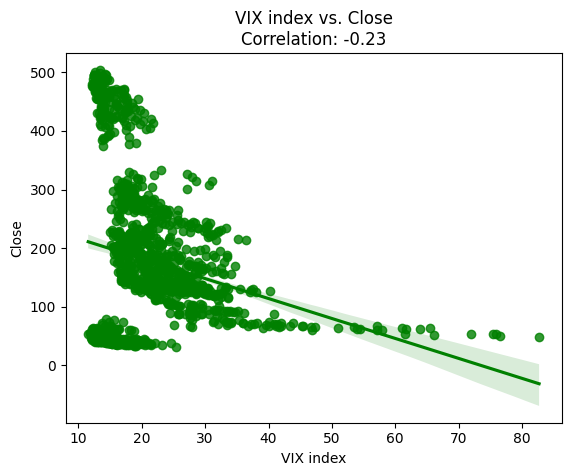

In [63]:
# Scatter plot
sns.regplot(x='VIX index', y='Close', data=df, color='green')
plt.title(f"VIX index vs. Close\nCorrelation: {correlation_vol:.2f}")
plt.xlabel("VIX index")
plt.ylabel("Close")
plt.show()

A correlation coefficient of -0.22500708756046248 indicates a negative correlation. The closer the value is to -1, the stronger the negative correlation. However, the value -0.225 suggests a relatively weak negative correlation.

In [64]:
# Calculate correlation between log returns and volume
correlation_leverage = df['log_Return'].corr(df['Volume'])
correlation_leverage

0.043212179348200146

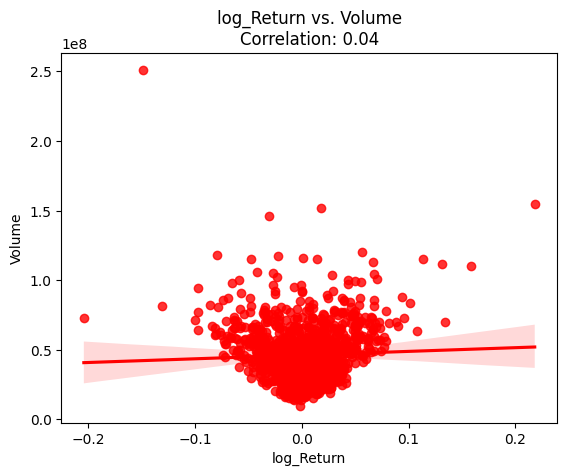

In [65]:
# Scatter plot
sns.regplot(x='log_Return', y='Volume', data=df, color='red')
plt.title(f"log_Return vs. Volume\nCorrelation: {correlation_leverage:.2f}")
plt.xlabel("log_Return")
plt.ylabel("Volume")
plt.show()

The leverage effect suggests that stocks tend to experience greater price movements when there is an increase in trading volumes. in our case the correlation between log_return and volume is positive i.e 0.043 which means the correlation is weak positive.

In [66]:
# Calculate correlation between log returns and volume
correlation_V = df['Volatility'].corr(df['VIX index'])
correlation_V

0.6094960566496175

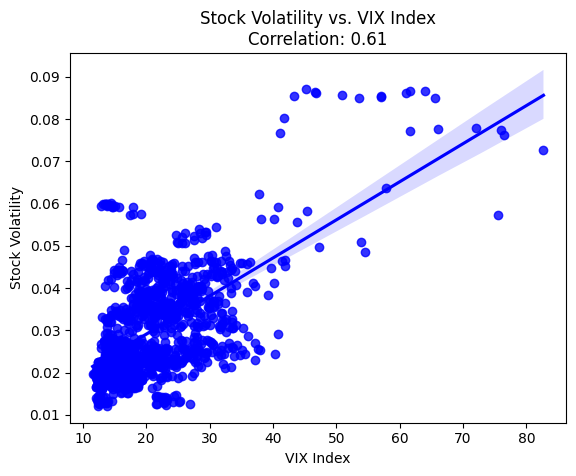

In [67]:
# Scatter plot
sns.regplot(x='VIX index', y='Volatility', data=df, color='blue')
plt.title(f"Stock Volatility vs. VIX Index\nCorrelation: {correlation_V:.2f}")
plt.xlabel("VIX Index")
plt.ylabel("Stock Volatility")
plt.show()

A correlation coefficient of 0.61 between stock volatility and the VIX (Volatility Index) signifies a moderately positive correlation. This positive correlation suggests that periods of higher stock market volatility are associated with higher values of the VIX. A positive correlation between stock volatility and the VIX is generally expected, as the VIX is designed to measure market volatility and is often referred to as the "fear index. A positive correlation could mean that monitoring the VIX can provide insights into potential changes in stock market volatility.

### Stress test

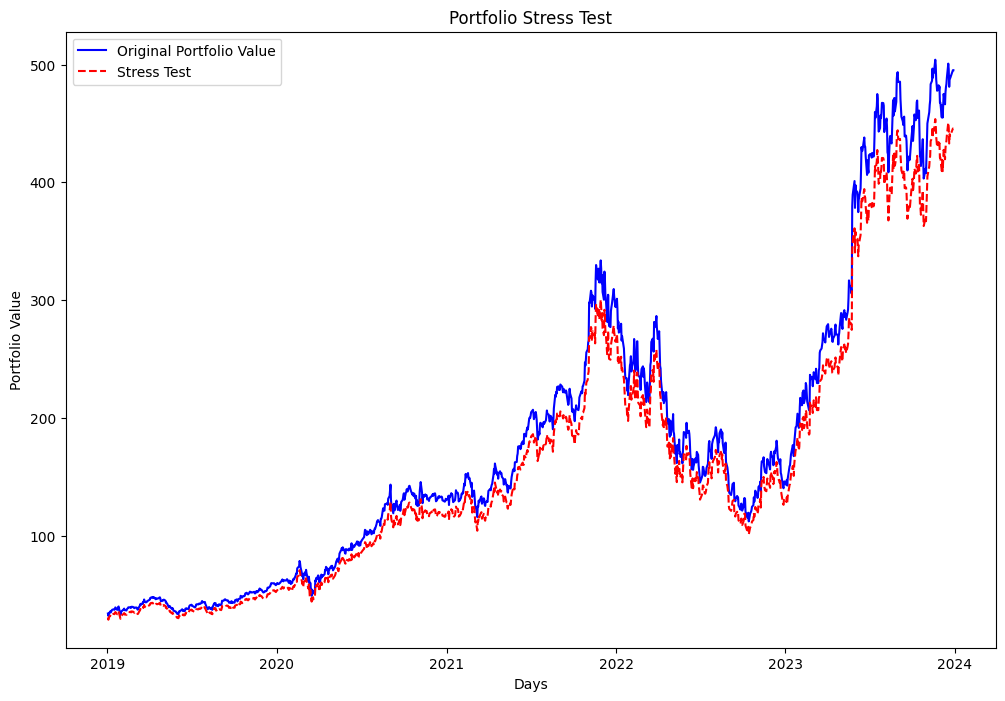

In [68]:
# Assuming 'Close' is the closing price column
portfolio_data = df[['Close']].copy()

def stress_test(portfolio_data, stress_factor=0.1):
    # Apply stress factor to simulate extreme scenarios
    stressed_portfolio_values = portfolio_data['Close'] * (1 - stress_factor)

    return stressed_portfolio_values

def plot_stress_test_results(original_data, stressed_values):
    plt.figure(figsize=(12, 8))
    plt.plot(original_data['Close'], label='Original Portfolio Value', color='blue')
    plt.plot(stressed_values, label='Stress Test', color='red', linestyle='--')

    plt.title('Portfolio Stress Test')
    plt.xlabel('Days')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.show()



stressed_values = stress_test(portfolio_data, stress_factor=0.1)

# Plot the results
plot_stress_test_results(portfolio_data, stressed_values)

In this simplified example, the stress_test_basic function applies a stress factor directly to the historical closing prices. The stressed_values represent the portfolio values under stress. The results are then plotted to compare the original portfolio values with the stressed scenario. hewre we are using 0.1 Stress factor which means we are checking how our portfolio will perform during extreme events of 10%. and we can see there is not very much difference in portfolio value and stress value.

### Technical Analysis

In [69]:
!pip install ta

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29421 sha256=df6722a5c3329069effcf417570a245fd09364f7d5f0bcb25f1c72d6b5b347ef
  Stored in directory: c:\users\lenovo\appdata\local\pip\cache\wheels\a1\d7\29\7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [70]:
from ta import add_all_ta_features
import ta

In [71]:
df = ta.add_all_ta_features(df, "Open", "High", "Low", "Close", "Volume", fillna=False)

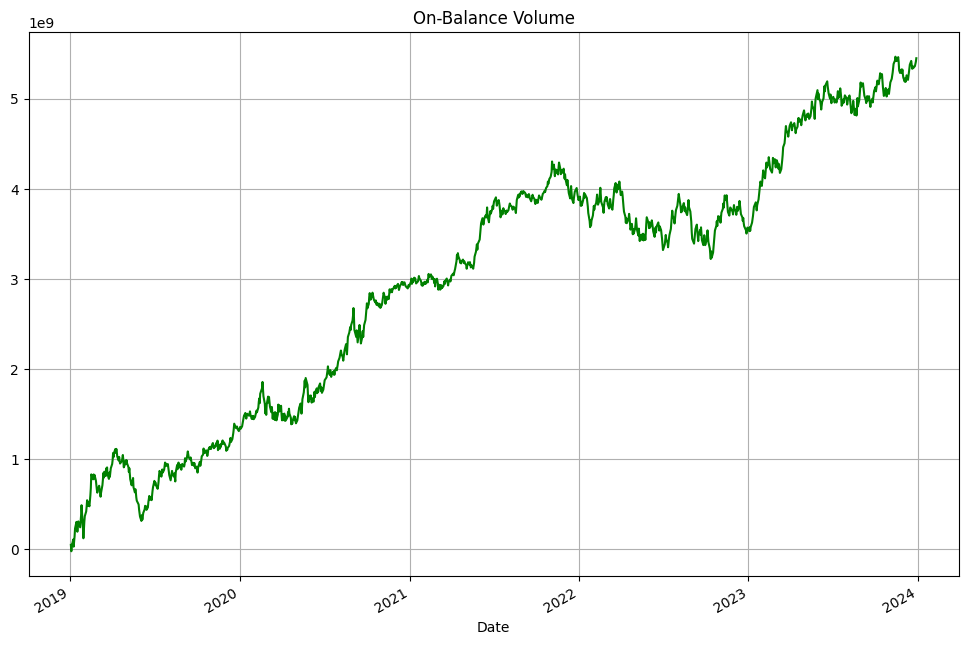

In [72]:
# Volume: On-Balance Volume
df["volume_obv"].plot(title='On-Balance Volume', color='g', figsize=(12,8))
plt.grid(True)

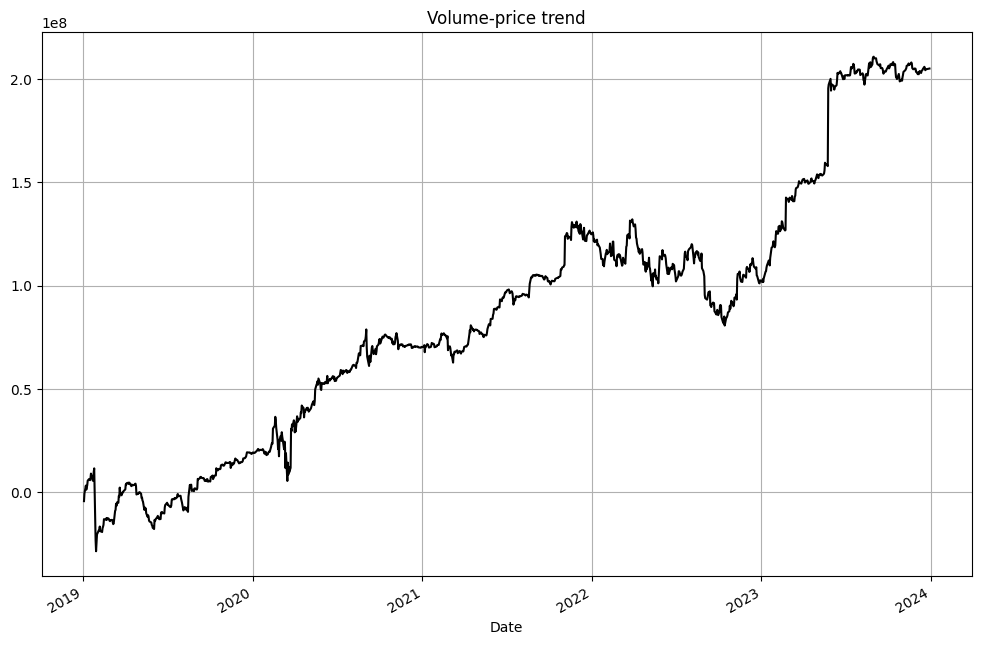

In [73]:
# Volume: Volume Price Trend
df["volume_vpt"].plot(title='Volume-price trend', color='black', figsize=(12,8))
plt.grid(True)

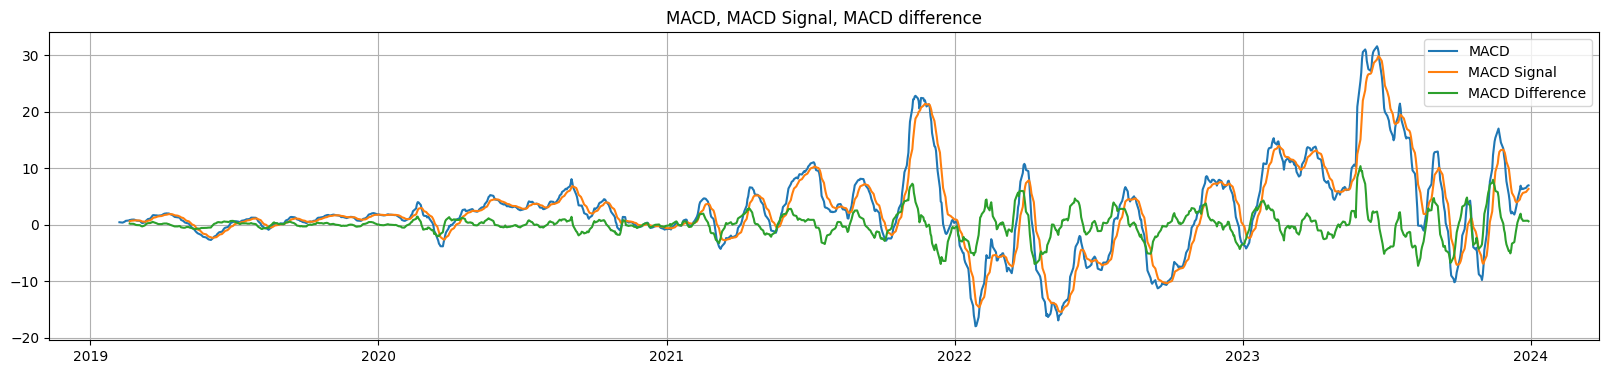

In [74]:
# Trend : MACD
fig, ax1 = plt.subplots(1, 1, figsize=(20, 4))
ax1.plot(df["trend_macd"], label='MACD')
ax1.plot(df["trend_macd_signal"], label='MACD Signal')
ax1.plot(df["trend_macd_diff"], label='MACD Difference')
#ax1.plot(df["Close"], label='NVDA Price')
plt.title('MACD, MACD Signal, MACD difference')
ax1.legend()
plt.grid(True)
plt.show()

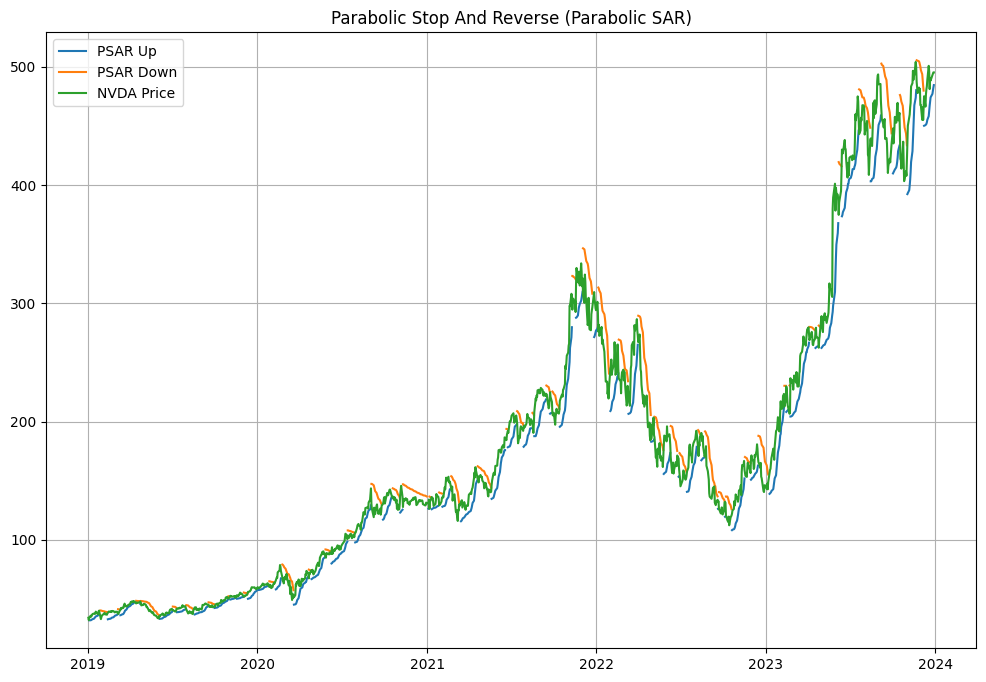

In [75]:
#Trend : Parabolic SAR
fig, ax2 = plt.subplots(1, 1, figsize=(12, 8))
ax2.plot(df["trend_psar_up"], label='PSAR Up')
ax2.plot(df["trend_psar_down"], label='PSAR Down')
ax2.plot(df["Close"], label='NVDA Price')
plt.title('Parabolic Stop And Reverse (Parabolic SAR)')
ax2.legend()
plt.grid(True)
plt.show()

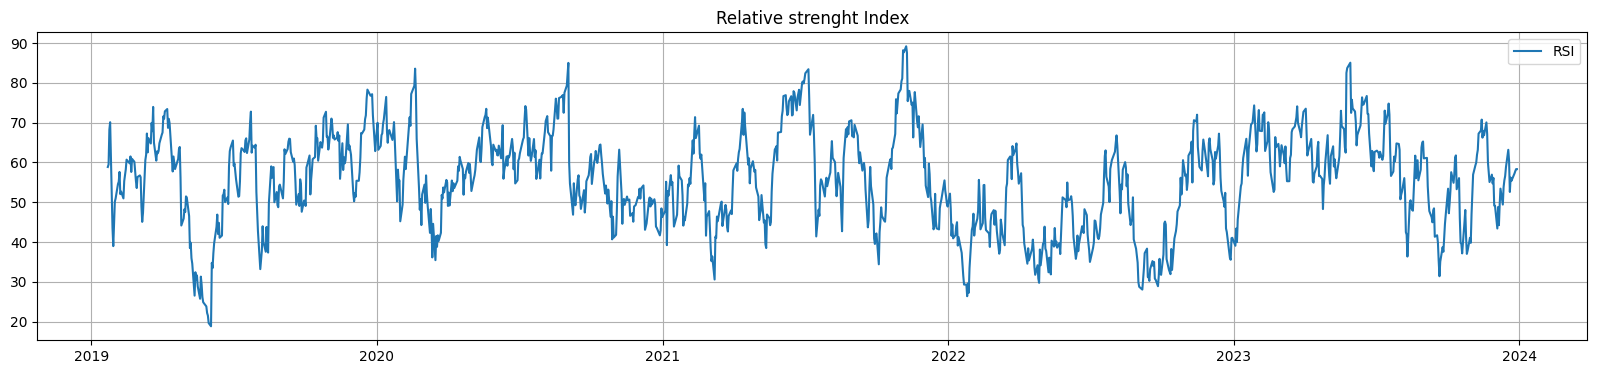

In [76]:
# Momentum : Relative Strenght Index
fig, ax3 = plt.subplots(1, 1, figsize=(20, 4))
ax3.plot(df["momentum_rsi"], label='RSI')
#ax3.plot(df["Close"], label='NVDA Price')
plt.title('Relative strenght Index')
ax3.legend()
plt.grid(True)
plt.show()

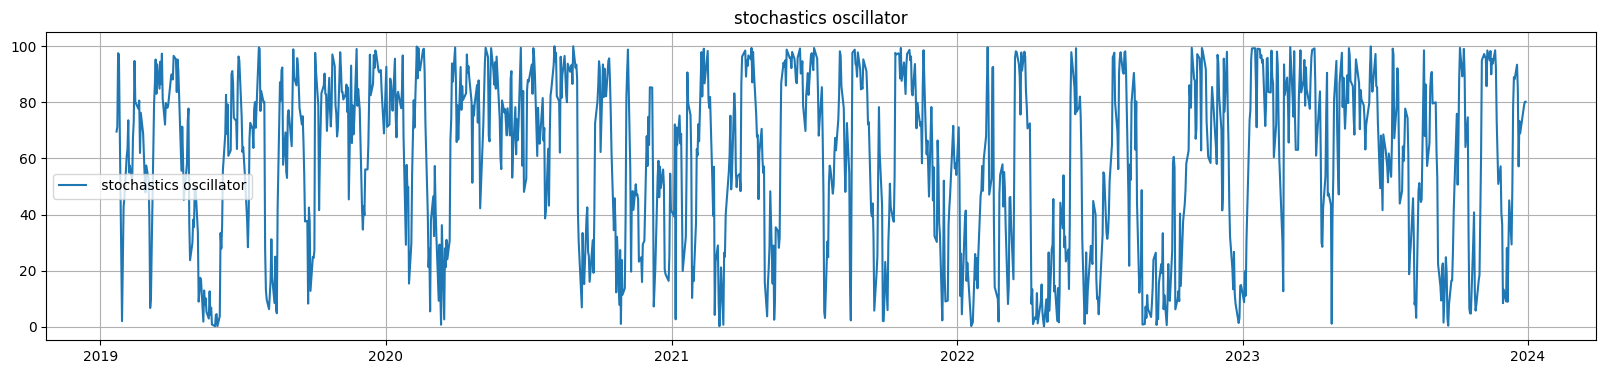

In [77]:
# Momentum : stochastics oscillator
fig, ax4 = plt.subplots(1, 1, figsize=(20, 4))
ax4.plot(df["momentum_stoch"], label=' stochastics oscillator')
#ax4.plot(df["momentum_stoch_signal"], label=' stochastics oscillator Signal')
plt.title('stochastics oscillator')
ax4.legend()
plt.grid(True)
plt.show()

### Fundamental Analysis

In [1]:
!pip install financetoolkit -U


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd

from financetoolkit import Toolkit

API_KEY = "aa4937f0afdc8136a24d30fd32fea303"

In [4]:
# Initialize the Toolkit with company tickers
companies = Toolkit(
    ["NVDA"], api_key=API_KEY, start_date="2019-01-02"
)

In [5]:
#getting company profile
companies.get_profile()


Obtaining company profiles: 100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


,NVDA
Symbol,NVDA
Price,693.32
Beta,1.6840000000000002
Average Volume,42346785
Market Capitalization,1712500400000
Last Dividend,0.16
Range,204.21-694.9699
Changes,31.72
Company Name,NVIDIA Corporation
Currency,USD


In [6]:
#Company Effective ratio
companies.ratios.get_effective_tax_rate()

Obtaining historical data: 100%|██████████| 2/2 [00:00<00:00,  8.62it/s]


date,2019,2020,2021,2022,2023
NVDA,-0.0629,0.0586,0.0175,0.019,-0.0447


In [7]:
#Overall Ratios
companies.ratios.collect_all_ratios()

,2019,2020,2021,2022,2023
Days of Inventory Outstanding,NaN,112.3145,81.5277,85.6719,121.9599
Days of Sales Outstanding,NaN,51.5005,44.7193,48.0017,57.3535
Operating Cycle,NaN,163.815,126.2471,133.6736,179.3134
Days of Accounts Payable Outstanding,NaN,52.6831,54.875,57.6947,46.7481
Cash Conversion Cycle,NaN,111.1318,71.3721,75.979,132.5652
...,...,...,...,...,...
EV-to-EBIT,37.3561,103.7918,162.0998,37.3401,281.3375
EV-to-EBITDA,36.3271,92.1712,130.8249,33.4781,216.7099
EV-to-Operating-Cash-Flow,39.4619,65.8808,127.8812,41.7226,221.5888
Tangible Asset Value,8724000000.0,11586000000.0,12700000000.0,22263000000.0,17729000000.0


In [8]:
#profitability Ratio
companies.ratios.collect_profitability_ratios()

date,2019,2020,2021,2022,2023
Gross Margin,0.6121,0.6199,0.6234,0.6493,0.5693
Operating Margin,0.3247,0.2607,0.2718,0.3731,0.1566
Net Profit Margin,0.3534,0.2561,0.2598,0.3623,0.1619
Interest Coverage Ratio,70.1034,65.4423,30.9293,48.0975,22.0153
Income Before Tax Profit Margin,0.3325,0.272,0.2644,0.3694,0.155
Effective Tax Rate,-0.0629,0.0586,0.0175,0.019,-0.0447
Return on Assets,NaN,0.1827,0.1879,0.2673,0.1023
Return on Equity,NaN,0.2595,0.2978,0.4483,0.1793
Return on Invested Capital,NaN,0.2443,0.2409,0.3233,0.1319
Return on Capital Employed,0.3305,0.1946,0.1847,0.2554,0.1283


In [9]:
#efficiency Ratios
companies.ratios.collect_efficiency_ratios()

date,2019,2020,2021,2022,2023
Days of Inventory Outstanding,NaN,112.3145,81.5277,85.6719,121.9599
Days of Sales Outstanding,NaN,51.5005,44.7193,48.0017,57.3535
Operating Cycle,NaN,163.815,126.2471,133.6736,179.3134
Days of Accounts Payable Outstanding,NaN,52.6831,54.875,57.6947,46.7481
Cash Conversion Cycle,NaN,111.1318,71.3721,75.979,132.5652
Cash Conversion Efficiency,0.3195,0.4361,0.3491,0.3384,0.2091
Receivables Turnover,NaN,0.1411,0.1225,0.1315,0.1571
Inventory Turnover Ratio,NaN,3.2498,4.477,4.2604,2.9928
Accounts Payable Turnover Ratio,NaN,6.9282,6.6515,6.3264,7.8078
SGA-to-Revenue Ratio,0.0846,0.1001,0.1163,0.0805,0.0905


In [10]:
#liquidty Ratio
companies.ratios.collect_liquidity_ratios()

date,2019,2020,2021,2022,2023
Current Ratio,7.9436,7.6738,4.0904,6.6503,3.5156
Quick Ratio,6.6561,7.037,3.5643,5.9649,2.609
Cash Ratio,5.5847,6.1082,2.9455,4.8923,2.0259
Working Capital,9228000000.0,11906000000.0,12130000000.0,24494000000.0,16510000000.0
Operating Cash Flow Ratio,2.8164,2.6687,1.4833,2.101,0.8595
Operating Cash Flow to Sales Ratio,0.3195,0.4361,0.3491,0.3384,0.2091
Short Term Coverage Ratio,1.5044,2.4428,1.9064,1.6645,0.7239


In [11]:
#debt-to-Equity Ratio
companies.ratios.get_debt_to_equity_ratio()

date,2019,2020,2021,2022,2023
NVDA,0.2128,0.2091,0.4497,0.4392,0.5364


### Risk Modelling

In [12]:
#Dupont Anlysis
companies.models.get_dupont_analysis()

date,2019,2020,2021,2022,2023
Net Profit Margin,0.3534,0.2561,0.2598,0.3623,0.1619
Asset Turnover,NaN,0.7134,0.7233,0.7376,0.6319
Equity Multiplier,NaN,1.4205,1.5846,1.6775,1.7525
Return on Equity,NaN,0.2595,0.2978,0.4483,0.1793


In [13]:
#WACC (Weighted Avg cost of Caital) Anlysis
companies.models.get_weighted_average_cost_of_capital(growth=True, lag=[1, 2, 3])

2019    2020    2021    2022    2023
Market Value Equity              Lag 1   NaN   1.198  1.2912 -0.4981  2.3526
                                 Lag 2   NaN     NaN   4.036    0.15  0.6828
                                 Lag 3   NaN     NaN     NaN  1.5277  2.8556
Market Value Debt                Lag 1   NaN  0.2837  1.9769  0.5384  0.0144
                                 Lag 2   NaN     NaN  2.8214  3.5795  0.5605
                                 Lag 3   NaN     NaN     NaN  4.8788  3.6454
Cost of Equity                   Lag 1   NaN -0.6391  1.2832 -1.7929 -2.0956
                                 Lag 2   NaN     NaN  -0.176 -2.8104 -0.1313
                                 Lag 3   NaN     NaN     NaN -1.6534  0.9834
Cost of Debt                     Lag 1   NaN -0.3016  0.1886 -0.1663  0.0944
                                 Lag 2   NaN     NaN -0.1698  -0.009 -0.0875
                                 Lag 3   NaN     NaN     NaN -0.3079  0.0846
Corporate Tax Rate               Lag 1   NaN -1.9316 -0.7019  0.0886 -3.3525
                                 Lag 2   NaN     NaN -1.2777 -0.6755  -3.561
                                 Lag 3   NaN     NaN     NaN -1.3023 -1.7634
Weighted Average Cost of Capital Lag 1   NaN -0.6371  1.2774 -1.7751 -2.1216
                                 Lag 2   NaN     NaN -0.1735 -2.7653 -0.1306
                                 Lag 3   NaN     NaN     NaN -1.6407  0.9799

In [14]:
# Altman-Z Score
companies.models.get_altman_z_score()

2019    2020    2021    2022    2023
NVDA Working Capital to Total Assets    0.6943  0.6876  0.4213  0.5543  0.4009
     Retained Earnings to Total Assets  0.9453  0.8646  0.6567  0.3674   0.247
     EBIT to Total Assets               0.2975  0.1745  0.1595  0.2303  0.1079
     Market Value to Total Liabilities 37.0886 63.0019 62.0083 21.0704 65.0656
     Sales to Total Assets              0.8814  0.6306  0.5792  0.6091   0.655
     Altman Z-Score                    26.2728 41.0433 39.7356  15.191 40.8772

<Axes: title={'center': 'Piotroski Score'}, xlabel='date'>

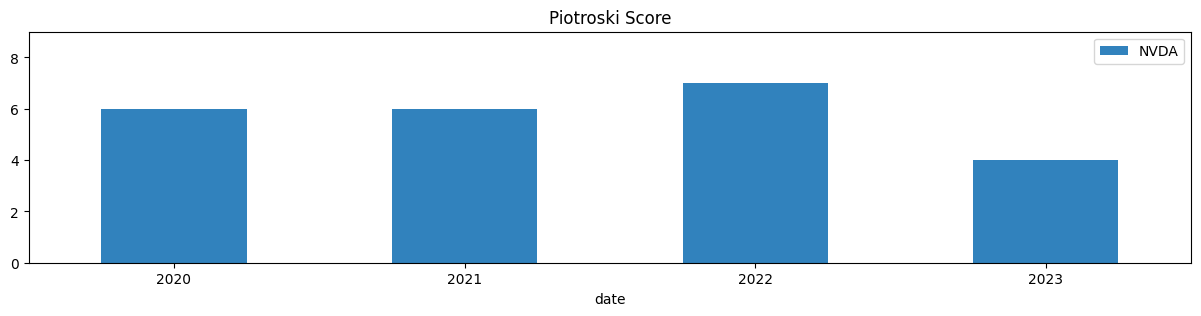

In [15]:
#Piotroski score

companies.models.get_piotroski_score().loc[:, "Piotroski Score", :].T.plot.bar(
    figsize=(15, 3), rot=0, title="Piotroski Score", colormap="tab20c", ylim=(0, 9)
)

In [16]:
#VaR: Value at Risk
companies.risk.get_value_at_risk()

,NVDA,Benchmark
2018,-0.048,-0.0209
2019,-0.0355,-0.012
2020,-0.0561,-0.0314
2021,-0.0404,-0.0131
2022,-0.0656,-0.0262
2023,-0.0346,-0.0139
2024,-0.0188,-0.0078


In [17]:
# CVaR: Conditional Value at Risk
companies.risk.get_conditional_value_at_risk(period="yearly")

,NVDA,Benchmark
2018,-0.0834,-0.0275
2019,-0.0548,-0.0196
2020,-0.0811,-0.0545
2021,-0.0541,-0.0183
2022,-0.0781,-0.0335
2023,-0.0438,-0.0157
2024,-0.0236,-0.0122


In [18]:
# Ulcer Index
companies.risk.get_ulcer_index(period="yearly", growth=True)


,NVDA,Benchmark
2018,NaN,NaN
2019,-0.3822,-0.557
2020,0.1962,2.7895
2021,-0.1982,-0.7731
2022,1.0884,2.6497
2023,-0.6044,-0.5857
2024,-0.8663,-0.7312


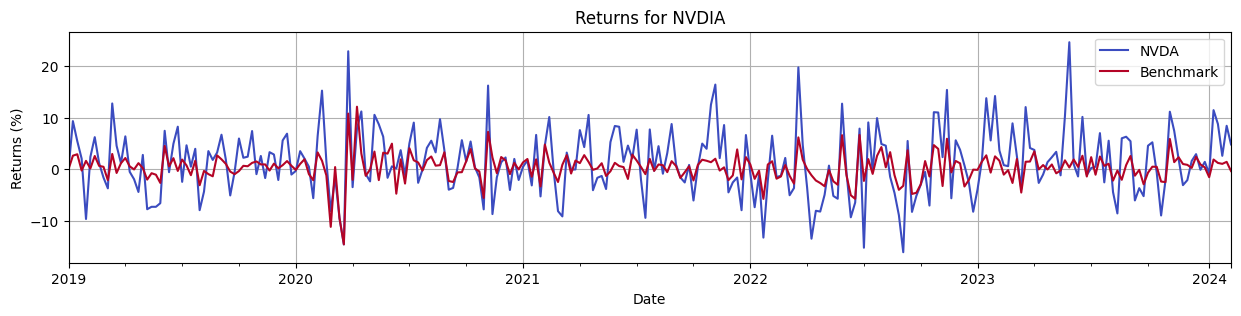

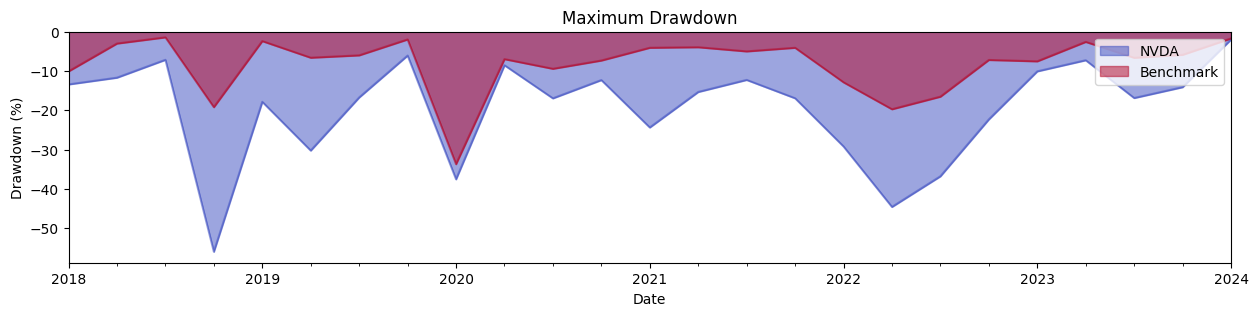

In [21]:
#Drawdown performance
(companies.get_historical_data(period="weekly")["Return"] * 100).plot(
    figsize=(15, 3),
    title="Returns for NVDIA",
    grid=True,
    xlabel="Date",
    ylabel="Returns (%)",
    colormap="coolwarm",
)

plt.legend(loc="upper right")

(companies.risk.get_maximum_drawdown(period="quarterly") * 100).plot.area(
    stacked=False,
    figsize=(15, 3),
    title="Maximum Drawdown",
    xlabel="Date",
    ylabel="Drawdown (%)",
    colormap="coolwarm",
)

plt.legend(loc="upper right")

In [22]:
# NVDIA Beta
companies.performance.get_beta()

,NVDA
Date,
2019,2.2687
2020,1.3649
2021,2.0148
2022,2.2014
2023,2.0227
2024,2.1026


In [23]:
# CAPM : Capital asset pricing Model
companies.performance.get_capital_asset_pricing_model(period="yearly")

,NVDA
Date,
2019,0.6839
2020,0.2468
2021,0.5635
2022,-0.4468
2023,0.4896
2024,0.0305


<Axes: title={'center': '12-Month Rolling Sharpe Ratio'}, xlabel='Date', ylabel='Sharpe Ratio'>

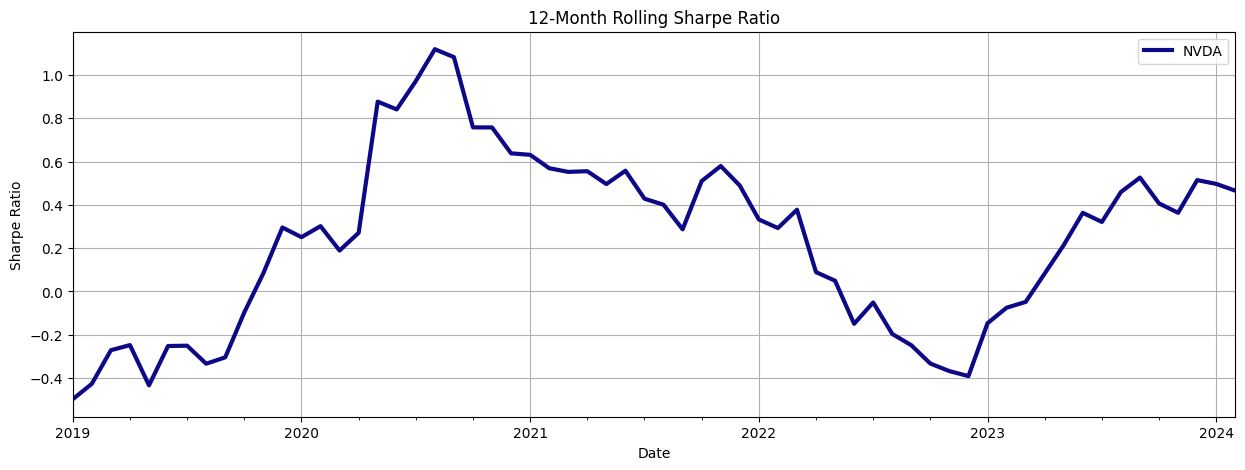

In [24]:
#12-Month Rolling Sharpe Ratio

companies.performance.get_sharpe_ratio(period="monthly", rolling=12).plot(
    figsize=(15, 5),
    title="12-Month Rolling Sharpe Ratio",
    grid=True,
    colormap="plasma",
    lw=3,
    linestyle="-",
    ylabel="Sharpe Ratio",
    xlabel="Date",
)

In [25]:
fama_and_french = companies.performance.get_fama_and_french_model(
    period="yearly", method="simple"
)

# Show the Fama and French 5 Factor Model Results
fama_and_french

Calculating Individual Factor Exposures: 100%|██████████| 1/1 [00:13<00:00, 13.42s/it]


NVDA                                                        \
        Mkt-RF                                                         
     Intercept   Slope R Squared P Value Standard Error Factor Value   
2019    0.2338 22.6596    0.4996     0.0         1.4344         0.28   
2020   -0.0009 47.8862    0.6488     0.0         2.2239         0.39   
2021    0.0181 19.1214    0.3755     0.0         1.5595        -0.31   
2022    0.1776 34.0762    0.7288     0.0         1.3172        -0.22   
2023    0.2841 14.8836    0.2839     0.0         1.5009        -0.43   

                                            ...                              \
                     SMB                    ...            RMW                
     Residuals Intercept   Slope R Squared  ... Standard Error Factor Value   
2019   -5.8092    0.0107  4.8636     0.063  ...         0.7938        -0.12   
2020  -17.4518    0.0235 -0.4705    0.0003  ...         1.0038         0.57   
2021    7.1642   -0.0004  0.2062       0.0  ...         1.5445         0.36   
2022    6.8165    0.0218  3.2594    0.0512  ...         1.2145        -0.54   
2023    8.5059   -0.0372 -1.6337    0.0049  ...         1.0651         0.67   

                                                                   \
                     CMA                                            
     Residuals Intercept   Slope R Squared P Value Standard Error   
2019    0.7524   -0.0388 -4.3808    0.1547     0.0         0.6476   
2020    1.1826   -0.0291 -3.3657    0.0733     0.0         0.7555   
2021    4.7491    0.0683 -7.6259    0.1561     0.0         1.1214   
2022   -5.4233    0.0025 -12.868     0.393     0.0         1.0134   
2023    3.5815   -0.1983 -9.5788    0.3738     0.0         0.7873   

                             
                             
     Factor Value Residuals  
2019         0.25    1.9033  
2020        -0.24    0.4443  
2021          0.4    4.2368  
2022          0.0   -0.5051  
2023        -0.07    1.9179  

[5 rows x 35 columns]

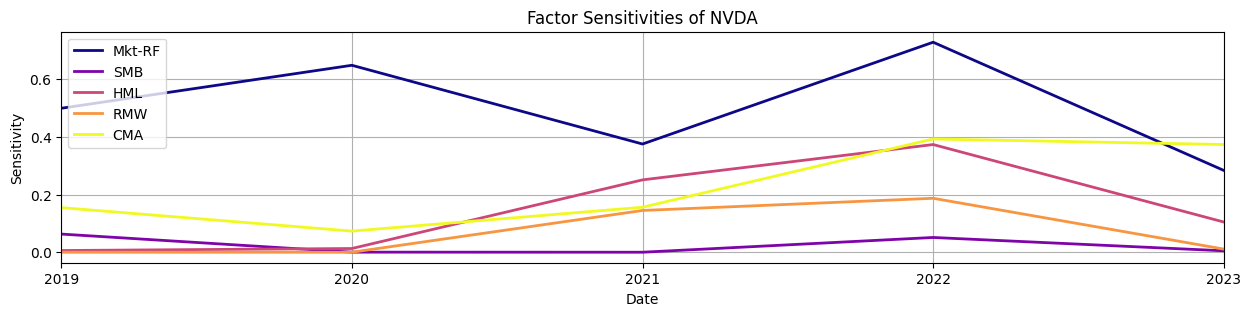

In [26]:
# R-Sqauared over time
for ticker in companies._tickers:
    fama_and_french[ticker].xs("R Squared", level=1, axis=1).plot(
        figsize=(15, 3),
        title=f"Factor Sensitivities of {ticker}",
        grid=True,
        colormap="plasma",
        lw=2,
        linestyle="-",
        ylabel="Sensitivity",
        xlabel="Date",
    )

In [27]:
#Factor Asset Correlations
companies.performance.get_factor_asset_correlations(period="yearly")


Calculating Factor Asset Correlations: 100%|██████████| 1/1 [00:06<00:00,  6.03s/it]


NVDA                                
     Mkt-RF     SMB     HML     RMW     CMA
2019 0.7068  0.2511 -0.0766 -0.0031 -0.3933
2020 0.8055  -0.016 -0.1137  0.0056 -0.2707
2021 0.6128  0.0067 -0.5011 -0.3806 -0.3951
2022 0.8537  0.2263 -0.6113 -0.4326 -0.6269
2023 0.5329 -0.0699 -0.3238 -0.1044 -0.6114

### MacroEconomic Analysis

In [28]:
from financetoolkit import Economics

In [30]:
# United States GDP

economics = Economics(start_date='2019-01-02', end_date='2023-01-01')

real_gdp = economics.get_gross_domestic_product(inflation_adjusted=True)

real_gdp.loc[:, ['United States']]

,United States
2019,20136378.2764
2020,19690665.9565
2021,20832765.6564
2022,21235981.9981
2023,21737196.3148


<Axes: title={'center': 'Technology Sector Performance'}, ylabel='Date'>

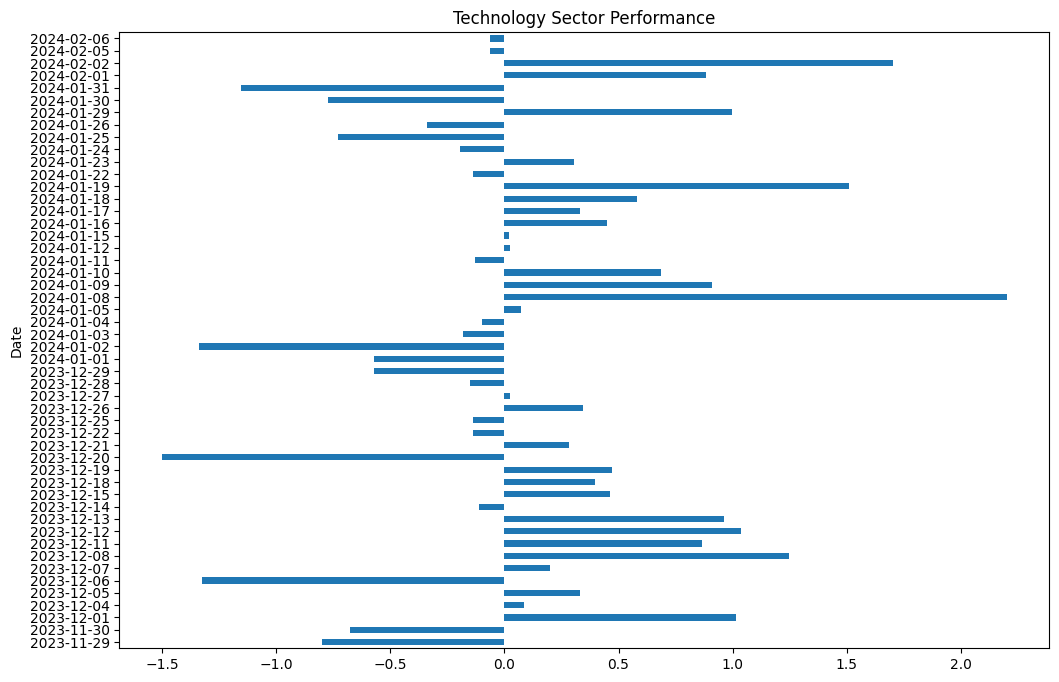

In [31]:
# Sector performance

from financetoolkit import Discovery

discovery = Discovery(api_key=API_KEY)

sectors_performance = discovery.get_sectors_performance()

sectors_performance['Technology'].plot(kind='barh', title='Technology Sector Performance', figsize=(12,8))

In [32]:
# Business Confidence Index

economics = Economics(start_date='2019-01-02', end_date='2023-01-01')

business_confidence_index = economics.get_business_confidence_index()

business_confidence_index.loc[:, ['United States']]

,United States
2019-01,100.5237
2019-02,100.3598
2019-03,100.2286
2019-04,100.0084
2019-05,99.8061
2019-06,99.6238
2019-07,99.4055
2019-08,99.131
2019-09,98.9231
2019-10,98.8567


In [34]:
#consumer confidence index

economics = Economics(start_date='2019-01-02', end_date='2023-01-01')

consumer_confidence_index = economics.get_consumer_confidence_index()

consumer_confidence_index.loc[:, ['United States']]

,United States
2019-01,101.0065
2019-02,101.0596
2019-03,101.2733
2019-04,101.4299
2019-05,101.5161
2019-06,101.4242
2019-07,101.1969
2019-08,100.9068
2019-09,100.9067
2019-10,101.1055


In [ ]:
# CPI Data

economics = Economics(start_date='2019-01-02', end_date='2023-01-01')

consumer_price_index = economics.get_consumer_price_index()

consumer_price_index.loc[:, ['United States']]

,United States
2019,107.8646
2020,109.1952
2021,114.325
2022,123.4742


In [35]:
# PPI Data
economics = Economics(start_date='2019-01-02', end_date='2023-01-01')

producer_price_index = economics.get_producer_price_index(period='yearly')

producer_price_index.loc[:, ['United States']]

,United States
2019,106.0676
2020,103.8489
2021,116.5109
2022,134.4598


In [36]:
#Long term Interest rate

economics = Economics(start_date='2019-01-02', end_date='2023-01-01')

long_term_interest_rate = economics.get_long_term_interest_rate(period='yearly')

long_term_interest_rate.loc[:, ['United States']]

,United States
2019,0.0214
2020,0.0089
2021,0.0144
2022,0.0295


In [37]:
#Short term Interest rate

economics = Economics(start_date='2019-01-02', end_date='2023-01-01')

short_term_interest_rate = economics.get_short_term_interest_rate(period='yearly', forecast=True)

short_term_interest_rate.loc[:, ['United States']]


,United States
2019,0.0221
2020,0.0062
2021,0.0011
2022,0.0223
2023,0.0518
2024,0.0501
2025,0.0419


In [38]:
# Federal Reserve Rates

economics = Economics(start_date='2019-01-02')

effr = economics.get_federal_reserve_rates()

effr.loc[:, ['Rate', '1st Percentile', '25th Percentile', '75th Percentile', '99th Percentile']]

,Rate,1st Percentile,25th Percentile,75th Percentile,99th Percentile
Effective Date,,,,,
2019-01-02,0.024,0.0236,0.024,0.0241,0.026000000000000002
2019-01-03,0.024,0.023399999999999997,0.024,0.0241,0.026000000000000002
2019-01-04,0.024,0.023700000000000002,0.024,0.0241,0.026000000000000002
2019-01-07,0.024,0.023399999999999997,0.024,0.0241,0.026000000000000002
2019-01-08,0.024,0.0235,0.024,0.0241,0.026000000000000002
...,...,...,...,...,...
2024-01-29,0.0533,0.053099999999999994,0.053200000000000004,0.0533,0.0545
2024-01-30,0.0533,0.053099999999999994,0.053200000000000004,0.0533,0.055
2024-01-31,0.0533,0.053,0.053200000000000004,0.053399999999999996,0.055


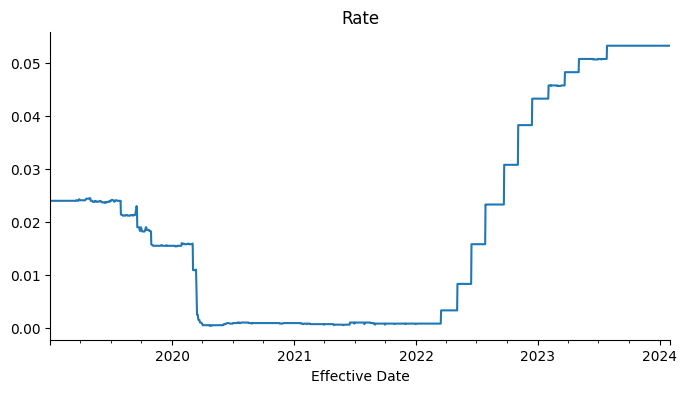

In [40]:
from matplotlib import pyplot as plt
effr['Rate'].plot(kind='line', figsize=(8, 4), title='Rate')
plt.gca().spines[['top', 'right']].set_visible(False)